- ほかの target をつかってみる

In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 
from glob import glob

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics

# Config

In [3]:
class cfg:
    exp = "exp010"
    dataset_path = "../dataset/v5.0"
    feature_set = "medium"
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [4]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set][:80]
targets = feature_metadata["targets"]

# 一旦2つだけ使用する
targets = ["target", "target_agnes_20"]

print(f"feature col length: {len(feature_set)}")
print(f"target col length: {len(targets)}")

feature col length: 80
target col length: 2


In [5]:
# print([col for col in targets if "20" in col])

# Load Data

In [12]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
).reset_index(drop=True)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
).reset_index(drop=True)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 83)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target,target_agnes_20
0,0001,1,2,3,2,3,2,2,2,3,...,0,2,2,3,2,2,3,2,0.25,0.25
1,0001,3,2,4,1,0,2,3,2,4,...,3,2,2,4,1,2,3,2,0.25,0.25


(3565569, 83)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target,target_agnes_20
0,0575,2,1,2,4,0,4,0,0,2,...,0,0,0,0,4,0,2,3,0.75,0.75
1,0575,0,2,2,3,2,3,0,0,4,...,4,3,3,4,3,3,4,1,0.00,0.00


# Preprocess

In [13]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)

# Training

In [14]:
features = feature_set
models = []

In [15]:
for target in targets:
    for i in range(4):
        cond_train = train["era_int"] % 4 == i
        tmp_train = train.loc[cond_train]

        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(valid[features], valid[target]),
            early_stopping_rounds=10
        )

        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))
        models.append(model)

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

        
del train; gc.collect()

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 689317, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 684034, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 689317, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 684034, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

159

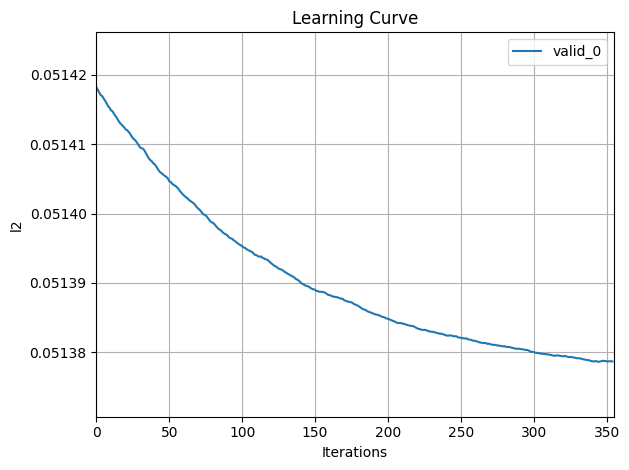

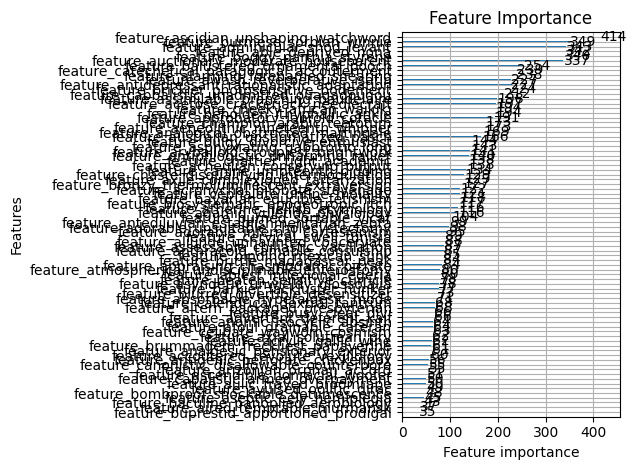

In [19]:
model.visualize_learning_curve()
model.visualize_feature_importance()

# Validation

In [9]:
if len(models) == 0:
    del train; gc.collect()
    model_paths = list(glob(os.path.join(cfg.exp, "model*.pkl")))
    for model_path in model_paths:
        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.load_model(model_path)
        models.append(model)
        

preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds

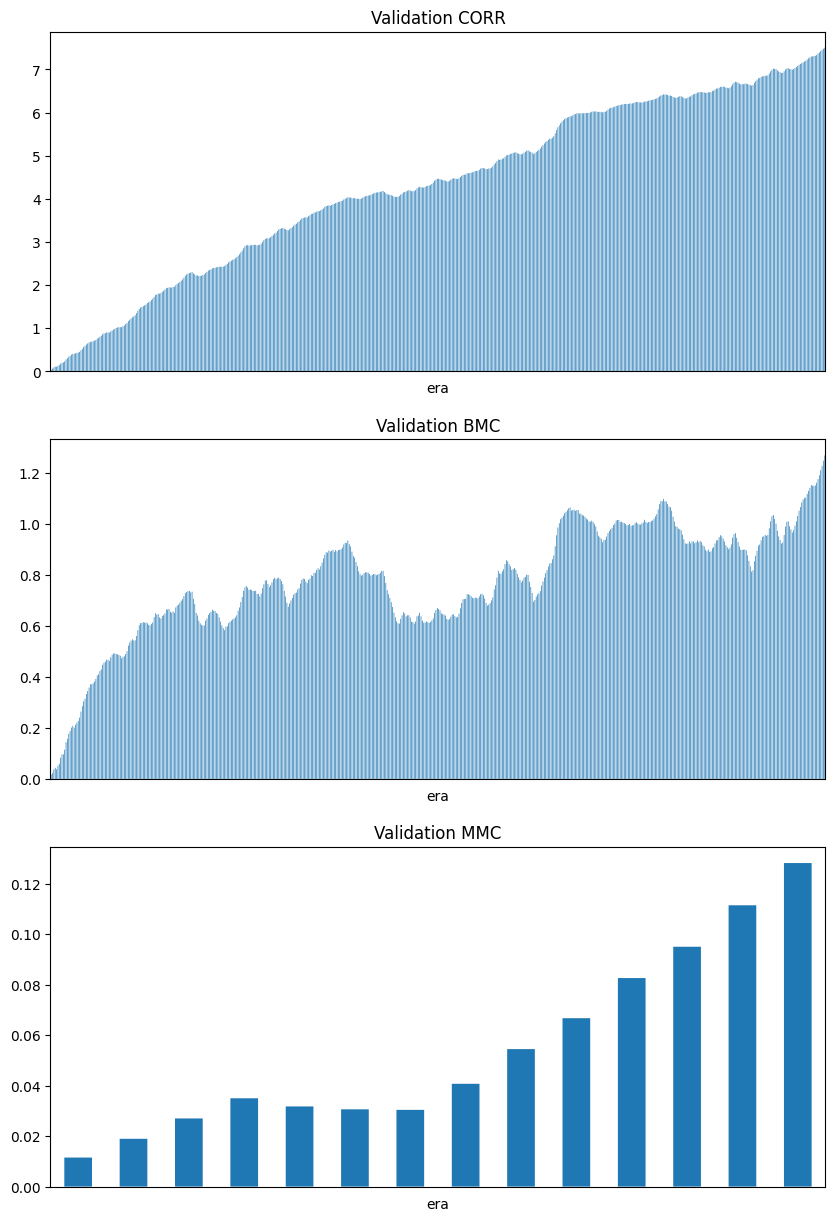

,corr_mean,corr_std,corr_shape,corr_max_drawdown,mmc_mean,mmc_std,mmc_shape,mmc_max_drawdown,bmc_mean,bmc_std,bmc_shape,bmc_max_drawdown
0,0.013116,0.016652,0.787658,0.137897,0.009156,0.006544,1.399179,0.004589,0.002216,0.012008,0.184526,0.325501


In [10]:
results, per_era_corr, per_era_bmc, per_era_mmc = caluculate_metrics(cfg.dataset_path, valid[["era", "pred", "target"]])
display(results)

In [24]:
per_era_corr

,pred
era,
0575,0.035389
0576,0.027082
0577,0.028544
0578,0.017219
0579,-0.000980
...,...
1142,0.026344
1143,0.030122
1144,0.030416


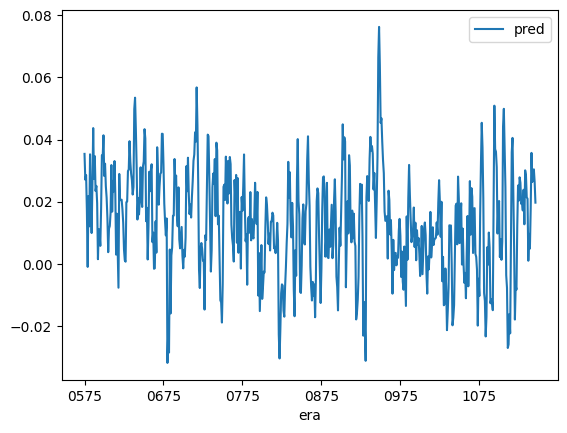

In [14]:
per_era_corr.plot()
plt.show()

In [49]:
era_valid = pd.DataFrame(valid.groupby("era")["feature_anthracoid_tamable_consulship"].mean())
era_valid.columns = ["mean"]

In [50]:
era_valid["corr"] = per_era_corr
display(era_valid.head())

,mean,corr
era,,
0575,2.000000,0.035389
0576,2.000000,0.027082
0577,2.000000,0.028544
0578,1.999654,0.017219
0579,2.000000,-0.000980


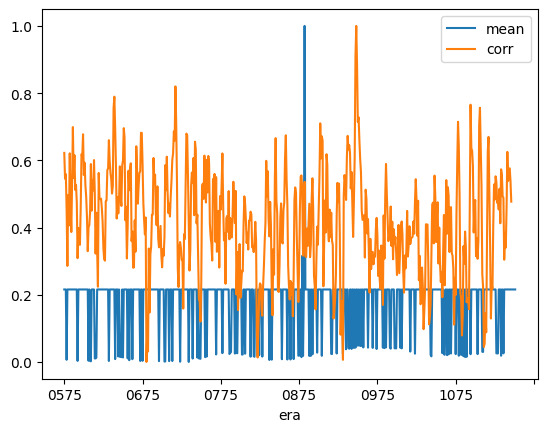

In [51]:
era_valid["mean_norm"] = (era_valid["mean"] - era_valid["mean"].min()) / (era_valid["mean"].max() - era_valid["mean"].min())
era_valid["corr_norm"] = (era_valid["corr"] - era_valid["corr"].min()) / (era_valid["corr"].max() - era_valid["corr"].min())


era_valid["mean_norm"].plot(label="mean")
era_valid["corr_norm"].plot(label="corr")


plt.legend()
plt.show()

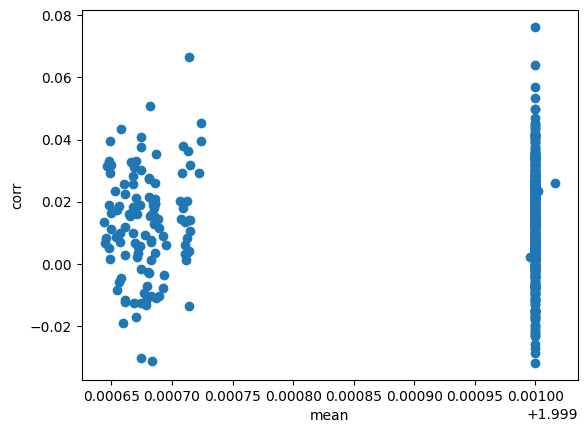

In [31]:
plt.scatter(era_valid["mean"], era_valid["corr"])
plt.xlabel("mean")
plt.ylabel("corr")
plt.show()

In [43]:
valid.groupby("era")[features].std().std(axis=0).reset_index().sort_values(0, ascending=False)


,index,0
23,feature_anthracoid_tamable_consulship,0.000200
3,feature_accoutered_revolute_vexillology,0.000075
29,feature_arizonian_orphan_accord,0.000075
7,feature_acrylic_gallic_wine,0.000075
58,feature_brickier_photosensitive_bodement,0.000075
...,...,...
40,feature_auctionary_moderate_houseparent,0.000075
36,feature_assimilable_branching_baudelaire,0.000075
22,feature_antediluvian_establishmentarian_zebra,0.000075
33,feature_aseptic_eely_hemiplegia,0.000075
